### Debug run crashes due to high speeds

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean

Error points:

1988-11
```
  ===>>> : E R R O R
             
          ===========
                     
   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests
                     
 kt 259655 |ssh| max   17.81     at i j   1328 310     MPI rank 376
 kt 259655 |U|   max   362.2     at i j k 1327 310   8 MPI rank 376
 kt 259655 Sal   min  0.1000     at i j k 1327 310   1 MPI rank 376
 kt 259655 Sal   max   35.66     at i j k  357 281  18 MPI rank 239
```

Same location as issue when using JRA (in 1979):

```
   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 22512 |ssh| max   4.214     at i j    373 451     MPI rank 743
 kt 22512 |U|   max   17.34     at i j k 1327 310   9 MPI rank 376
 kt 22512 Sal   min   25.67     at i j k  670 231  40 MPI rank 184
 kt 22512 Sal   max   48.56     at i j k 1328 310   8 MPI rank 376

```

In [91]:
folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/JRA55_1979_2000/'
year  = 1979
yind = 309; xind = slice(1320,1330);

dom   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240123-filledlakes.nc').isel(time_counter=0)
mask  = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240123-filledlakes.nc').isel(time_counter=0)
dsT   = xr.open_dataset(f'{folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc').isel(time_counter=0)
dsU   = xr.open_dataset(f'{folder}eANT025.L121_1m_{year}0101_{year}1231_grid_U.nc').isel(time_counter=0)
dsV   = xr.open_dataset(f'{folder}eANT025.L121_1m_{year}0101_{year}1231_grid_V.nc').isel(time_counter=0)
dsSBC = xr.open_dataset(f'{folder}eANT025.L121_1m_{year}0101_{year}1231_SBC.nc').isel(time_counter=0)

/tmp/ipykernel_2862/462611887.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm1=ax[1].pcolormesh(j_ind, mask.gdept_0.isel(y=yind1, x=xind1), plt_transect, vmin=-2, vmax=2)
/tmp/ipykernel_2862/462611887.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm2=ax[2].pcolormesh(i_ind, mask.gdept_0.isel(y=yind2, x=xind2), plt_transect, vmin=-2, vmax=2)


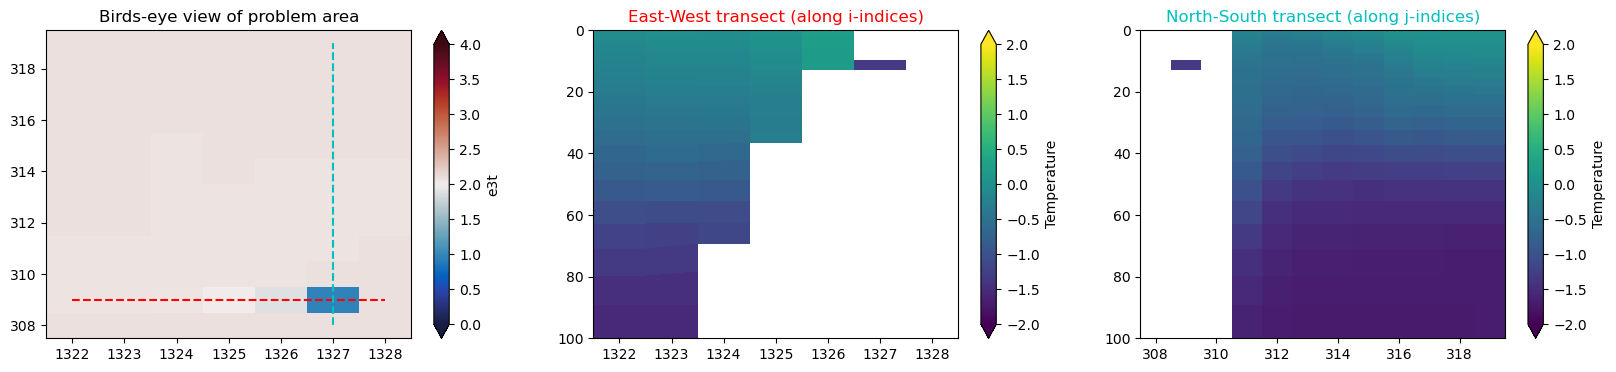

In [112]:
fig, ax = plt.subplots(1,3, figsize=(20,4))

ax[1].set_title('East-West transect (along i-indices)', color='r')
yind1 = 309; xind1 = slice(1322,1329);
plt_transect = xr.where(mask.tmask.isel(y=yind1, x=xind1).values==0, np.nan, dsT.thetao.isel(y_grid_T=yind1, x_grid_T=xind1).values)
j_ind = np.arange(xind1.start, xind1.stop)
cm1=ax[1].pcolormesh(j_ind, mask.gdept_0.isel(y=yind1, x=xind1), plt_transect, vmin=-2, vmax=2)

ax[2].set_title('North-South transect (along j-indices)', color='c')
yind2 = slice(308,320); xind2 = 1327;
i_ind = np.arange(yind2.start, yind2.stop)
plt_transect = xr.where(mask.tmask.isel(y=yind2, x=xind2).values==0, np.nan, dsT.thetao.isel(y_grid_T=yind2, x_grid_T=xind2).values)
cm2=ax[2].pcolormesh(i_ind, mask.gdept_0.isel(y=yind2, x=xind2), plt_transect, vmin=-2, vmax=2)

ax[0].set_title('Birds-eye view of problem area')
# ax[0].pcolormesh(j_ind, i_ind, dsT.thetao.isel(deptht=8, y_grid_T=yind2, x_grid_T=xind1), cmap=cmocean.cm.balance, vmin=-1, vmax=1)
cm0 = ax[0].pcolormesh(j_ind, i_ind, dsT.e3t.isel(deptht=8, y_grid_T=yind2, x_grid_T=xind1), cmap=cmocean.cm.balance, vmin=0, vmax=4)
ax[0].plot(j_ind, np.ones(j_ind.shape)*yind1, '--r')
ax[0].plot(np.ones(i_ind.shape)*xind2, i_ind, '--c')

fig.colorbar(cm0, ax=ax[0], label='e3t', extend='both')
fig.colorbar(cm1, ax=ax[1], label='Temperature', extend='both')
fig.colorbar(cm2, ax=ax[2], label='Temperature', extend='both')

for axis in ax[1:3].ravel():
    axis.set_ylim(100, 0)

In [124]:
np.unravel_index(dsT.e3t.isel(deptht=0).argmin(), dsT.e3t.isel(deptht=0).shape)

(364, 914)

In [138]:
for depth in range(0,121):
    min_e3t = dsT.e3t.isel(deptht=depth).min().values
    if min_e3t < 0.2:
        print(depth, '---', min_e3t, '---', np.unravel_index(dsT.e3t.isel(deptht=depth).argmin(), dsT.e3t.isel(deptht=depth).shape))

7 --- 0.17277575 --- (309, 1327)


In [140]:
sum(sum(dsT.e3t.isel(deptht=7) < 0.2))

<xarray.DataArray 'e3t' ()>
array(1)
Coordinates:
    deptht          float32 9.943
    time_centered   datetime64[ns] 1979-01-16T12:00:00
    time_counter    datetime64[ns] 1979-01-16T12:00:00
    nav_lat_grid_T  float32 -50.06

In [153]:
dom.e3t_0.isel(nav_lev=7, x=1327, y=309).values

array(0.37271751)

In [156]:
dom.e3t_1d.isel(nav_lev=7).values*0.2

0.3727175119067397

So, the issue is because there was one grid cell that had a partial cell thickness that was just too thin. It doesn't seem like that issue would exist anywhere else.

The cell thickness at time step 1 is exactly the minimum that it can be. But, the size of e3t at time step 2 is smaller than that.